# THIS NOTEBOOK DOES NOT USE OUR RASP-based MODEL

# Notebook description - Predicting details of errors made by the Wu et al 2023 baseline Encoder-Decoder Transformer on the ReCOGS_pos obj_pp_to_subj_pp split

This notebook: https://colab.research.google.com/drive/1Z0_EXV-bvmO2mRcnHmDpFuHIv4KHOpz-?usp=sharing (supplemental material for https://github.com/willy-b/RASP-for-ReCOGS paper)


**Related notebooks:**

Replaces https://colab.research.google.com/drive/1MiiEAchmaGulsTwNHs98-ill-UM7TK3i .

**For n=20 replications of overall accuracy of Wu et al 2023 baseline Encoder-Decoder Transformer on ReCOGS_pos see https://colab.research.google.com/drive/12mXX5L1I4rpwl1Jk8hCm-xyAkqiKJEo7#scrollTo=x2F3ZAY7uZjb , that is where our reported baseline scores come from, here I re-run 10 runs to get the specific errors made for detailed error prediction/analysis (also contains baseline layer variation experiments, n=3 and n=4 Transformer block comparison)**

See also https://colab.research.google.com/drive/1SOdNcVb4lfbeJTFfxs4HnFOf2GY_D-l4 for a test of the Wu et al 2023 baseline Encoder-Decoder Transformer on a new split we introduce
"v_dat_p2_pp_moved_to_recipient" which was predicted by our RASP model to be as difficult as obj_pp_to_subj_pp (the previously reported hardest generalization split) despite not involving subjects or nouns left of verb (same mechanism under our hypothesis but involves transferring prepositional phrase in existing examples from theme to recipient noun both right of verb as a totally independent check).

# Hypothesis: flat / non-tree pattern recognizer cannot ignore "pp np" inserted between related words and mistakes the now-closer prepositional noun for whatever relationship the word on the left had

Hypothesis:
The baseline Encoder-Decoder is doing flat (non-tree, non-recursive) pattern matching, and the cause of the extremely poor obj_pp_to_subj_pp generalization performance is that prepositional phrases add to the right, so when the subject is modified, in English given Subject-Verb-Object order, it is usually on the left of the verb it has a relationship with. When a noun on the left is modified by a preposition, it inserts a prepositional noun phrase to the right of it, before the verb it is related to, so the closest noun on the left of that verb has changed. When an object is modified by a prepositional phrase, it is usually on the right of the verb, and the prepositional phrase is added to the right of the noun, NOT in between the two related words and so does not affect the pattern recognizer looking for the verb and closest nouns.

## Side note, this is not specific to objects and subject pp
This is also hypothesized to not be specific to subjects and objects and in a separate notebook reported in the paper we predict (confirmed) a new hardest split "np v_dat_p2 np np" where the recipient np in the middle is modified by a prepositional phrase, which has the same problem though it is a totally different grammar form (transferring pp from theme noun to recipient noun).

Think in the limit the difference between np v_dat_p2 np np style sentences where the recipient is modified vs the theme with some long filler content:

"Emma gave a friend a cookie" ->
"Emma gave a friend a cookie (filler filler filler)" (not going to miss that a cookie was given as more filler is added)

vs

"Emma gave a friend (filler filler filler) a cookie" (as filler gets larger and has more distractors, may miss that a cookie was given to the friend due to the distance between friend and cookie increasing and distractors including nouns being added in between).
## Illustration

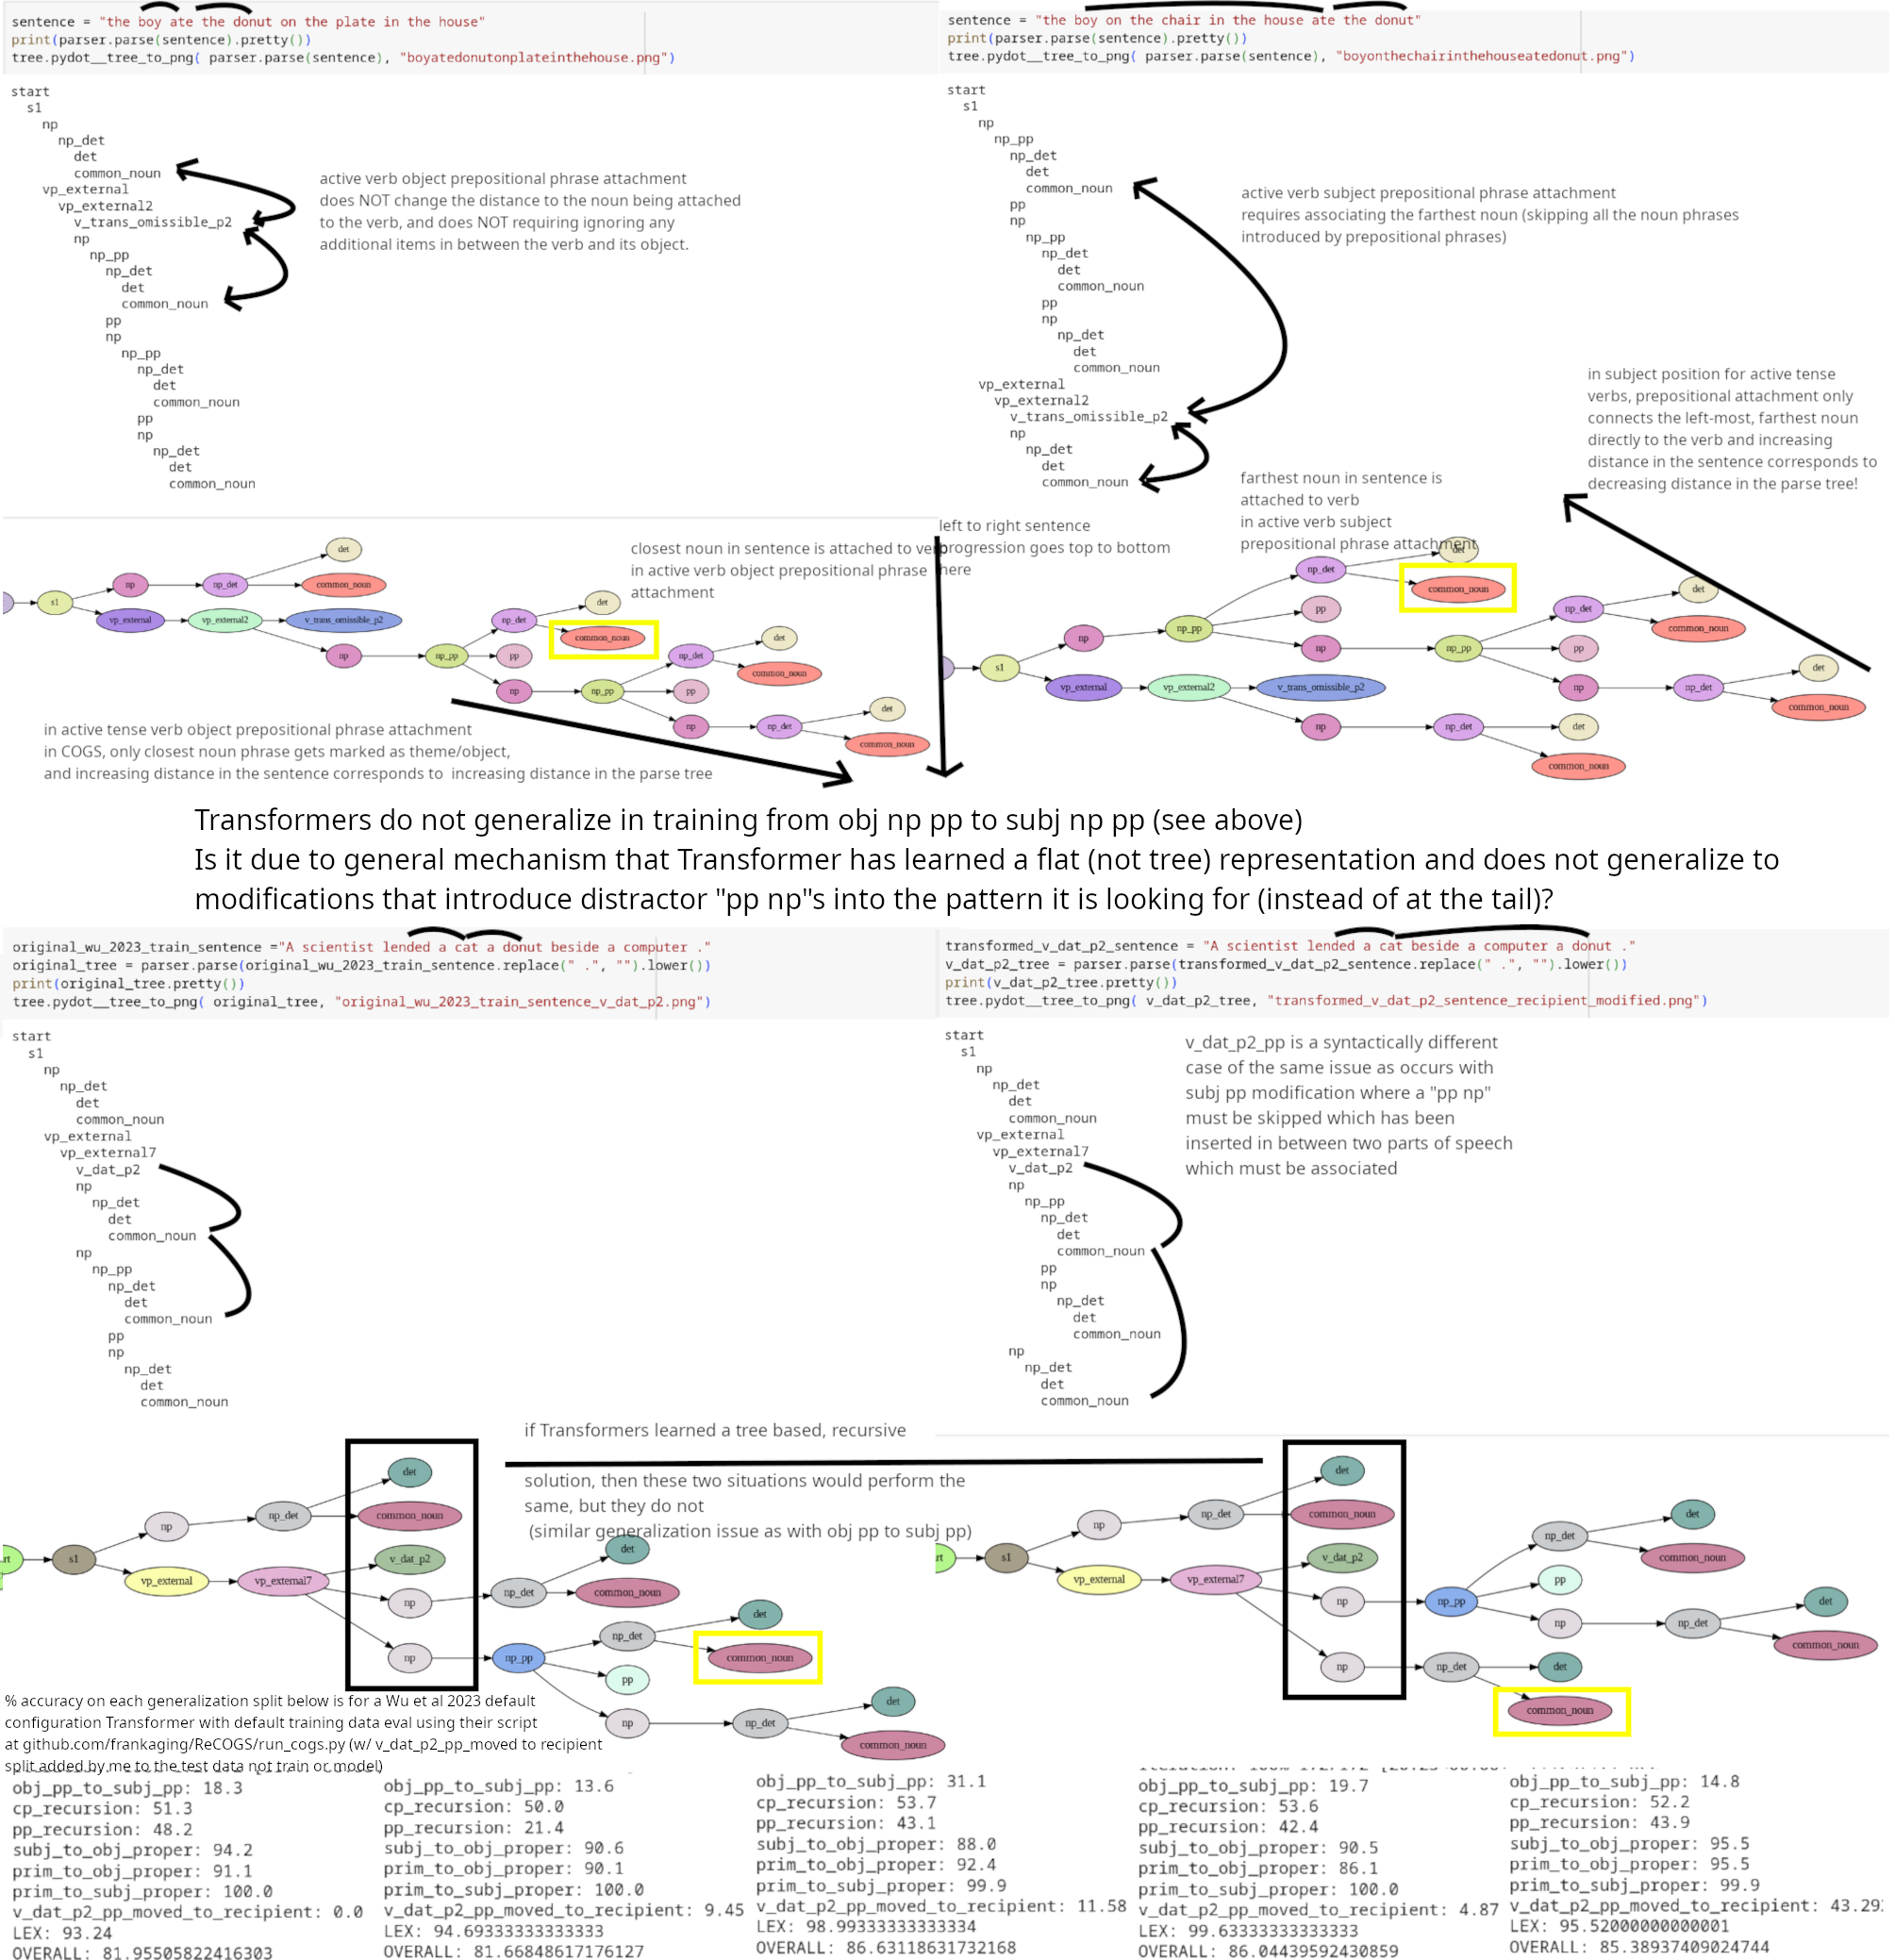

(stats at bottom of figure above are from https://colab.research.google.com/drive/1SOdNcVb4lfbeJTFfxs4HnFOf2GY_D-l4  )

# Training N Wu et al 2023 baseline Encoder-Decoder Transformers (using their official training scripts) and evaluating on the obj_pp_to_subj_pp generalization split (using the official script) and collecting the errors made (to explain them)

Retrieve the Wu et al 2023 baseline Encoder-Decoder Transformer code

In [ ]:
!pip install transformers==v4.45.2 # there is a breaking change for Wu et al 2023 in upstream huggingface Transformers after this version (see https://github.com/frankaging/ReCOGS/issues/1 )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 113.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [ ]:
%cd /content/
!rm -rf ReCOGS
!git clone https://github.com/frankaging/ReCOGS.git
%cd ReCOGS

/content
Cloning into 'ReCOGS'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 436 (delta 96), reused 92 (delta 73), pack-reused 312 (from 1)
Receiving objects: 100% (436/436), 84.71 MiB | 16.06 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (137/137), done.
/content/ReCOGS


Modify their script to log the errors for analysis, in run_cogs:
```
logging.basicConfig(filename="wu_et_al_2023_recogs_baseline_for_error_analysis.log")
```
and in do_gen condition, at https://github.com/frankaging/ReCOGS/blob/1b6eca8ff4dca5fd2fb284a7d470998af5083beb/run_cogs.py#L384 in the not eq condition (may add in all condition since saving the expected and actual columns then can confirm all examples get logged) add
`logging.info(f"Mistake (category {cat}): '{decoded_preds[i]}', Expected: '{decoded_labels[i]}', input: {input_labels[i]}")`

(was focused on getting it to run after distraction with upstream)

Run 1 seed at a time and collect the errors

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "42"


EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_42.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND theme ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 * donut ( 1 ) ; * mound ( 4 ) ; child ( 9 ) ; * computer ( 12 ) ; nmod . on ( 1 , 4 ) AND slide ( 6 ) AND theme ( 6 , 4 ) AND agent ( 6 , 9 ) AND nmod . on ( 9 , 12 )	* donut ( 1 ) ; * mound ( 4 ) ; child ( 9 ) ; * computer ( 12 ) ; nmod . on ( 1 , 4 ) AND slide ( 6 ) AND theme ( 6 , 1 ) AND agent ( 6 , 9 ) AND

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_42.log

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "66"

EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_66.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_66.log

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "77"

EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_77.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_77.log

Pause here, save results, resume in a few hours. Colab requires me to actively be engaged with this in order to keep it going, cannot run the A100 in the background.

On resume, repeat setup steps

In [ ]:
!pip install transformers==v4.45.2 # there is a breaking change for Wu et al 2023 in upstream huggingface Transformers after this version (see https://github.com/frankaging/ReCOGS/issues/1 )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [ ]:
%cd /content/
!rm -rf ReCOGS
!git clone https://github.com/frankaging/ReCOGS.git
%cd ReCOGS

/content
Cloning into 'ReCOGS'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 436 (delta 96), reused 92 (delta 73), pack-reused 312 (from 1)
Receiving objects: 100% (436/436), 84.71 MiB | 36.25 MiB/s, done.
Resolving deltas: 100% (303/303), done.
Updating files: 100% (137/137), done.
/content/ReCOGS


Modify their script to log the errors for analysis, in run_cogs:
```
logging.basicConfig(filename="wu_et_al_2023_recogs_baseline_for_error_analysis.log")
```
and in do_gen condition, at https://github.com/frankaging/ReCOGS/blob/1b6eca8ff4dca5fd2fb284a7d470998af5083beb/run_cogs.py#L384 in the not eq condition (may add in all condition since saving the expected and actual columns then can confirm all examples get logged) add
`logging.info(f"Mistake (category {cat}): '{decoded_preds[i]}', Expected: '{decoded_labels[i]}', input: {input_labels[i]}")`

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "88"

EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

have to keep session interactive or it stops saving on colab with A100 so it did not save end of log above, can print it from JSON file

In [ ]:
!cat /content/ReCOGS/results_recogs_positional_index_control/Dec-18-2024_ende_transformer_recogs_positional_index_cogs_seed_88.json

{
    "88_recogs_positional_index_cogs": {
        "obj_pp_to_subj_pp": 13.6,
        "cp_recursion": 50.0,
        "pp_recursion": 21.4,
        "subj_to_obj_proper": 90.6,
        "prim_to_obj_proper": 90.1,
        "prim_to_subj_proper": 100.0,
        "lex_acc": 94.69333333333333,
        "overall_acc": 85.05238095238096,
        "test_acc": 1.0
    }
}

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_88.tsv

In [ ]:
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_88.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_88.log

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "99"

EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_99.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 4 ) AND recipient ( 5 , 6 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_99.log

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "43"


EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
#!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_43.tsv

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_43.log

double check conversion of .log to .tsv for seed 43

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv  wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_43.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_43.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "67"


EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_67.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_67.log

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "78"


EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_78.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 4 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_78.log

connectivity issue caused incomplete saving and glitch in final command to save logs for last 2 seeds so ran again (they are random every time due to GPU anyway), not based on the results. (no code change, just fixed lag created glitch in shell command to save the output, this is also non-RASP model.)

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "89"


EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_89.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 8 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_89.log

In [ ]:
# baseline Wu et al 2023 model and baseline data
!python run_cogs.py --model_name ende_transformer --use_iiem --gpu 1 --train_batch_size 128 --eval_batch_size 128 --lr 0.0001 --data_path ./recogs_positional_index --output_dir ./results_recogs_positional_index_control --lfs cogs --do_train --do_test --do_gen --max_seq_len 512 --output_json --epochs 300 --seeds "100"


EncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Epoch: 0:   0% 0/213 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/tr

In [ ]:
# extract and move the error logs
!echo "actual	expected	input" > wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!cat wu_et_al_2023_recogs_baseline_for_error_analysis.log | grep obj_pp_to_subj_pp | sed -E 's/INFO:root:Mistake \(category obj_pp_to_subj_pp\)://g' | sed -E 's/, Expected: /	/g' | sed -E 's/, input: /	/g' | sed -E "s/'//g" >> wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!head -n 10 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv
!mv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp.tsv wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_100.tsv

actual	expected	input
 * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND scream ( 8 ) AND theme ( 8 , 1 ) AND agent ( 8 , 7 )	* baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )	The baby on a tray in the house screamed .
 * spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 4 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	* spokesman ( 1 ) ; * house ( 4 ) ; Emma ( 6 ) ; * rose ( 8 ) ; nmod . in ( 1 , 4 ) AND serve ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 )	The spokesman in the house served Emma the rose .
 donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND theme ( 5 , 1 ) AND agent ( 5 , 4 ) AND recipient ( 5 , 6 )	donkey ( 1 ) ; * room ( 4 ) ; Ella ( 6 ) ; donut ( 8 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 

In [ ]:
!mv wu_et_al_2023_recogs_baseline_for_error_analysis.log wu_et_al_2023_recogs_baseline_for_error_analysis_seed_100.log

Raw data was saved at https://drive.google.com/file/d/1FtZLNMhK2gpqlY9R_HvehoA-wsRgy-0j/view?usp=drive_link .

Switched to CPU instance from A100 now that finished training and evaluating the Wu et al 2023 baseline Encoder-Decoder Transformers

In [ ]:
!unzip /content/wu_et_al_2023_baseline_error_logs_contains_10_of_10_seeds__seeds_from_their_paper_and_seeds_plus_one_NOT_RASP_MODEL.zip

Archive:  /content/wu_et_al_2023_baseline_error_logs_contains_10_of_10_seeds__seeds_from_their_paper_and_seeds_plus_one_NOT_RASP_MODEL.zip
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_88.tsv  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_99.tsv  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis.log  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_seed_88.log  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_seed_99.log  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_42.tsv  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_66.tsv  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_77.tsv  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_seed_42.log  
  inflating: wu_et_al_2023_recogs_baseline_for_error_analysis_seed_66.log  
  inflating: wu_et_

In [ ]:
!ls -lart *.tsv

-rw-r--r-- 1 root root 276428 Dec 17 21:21 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_42.tsv
-rw-r--r-- 1 root root 257854 Dec 17 22:36 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_66.tsv
-rw-r--r-- 1 root root 225807 Dec 17 23:49 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_77.tsv
-rw-r--r-- 1 root root 279560 Dec 18 03:31 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_88.tsv
-rw-r--r-- 1 root root 274832 Dec 18 04:36 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_99.tsv
-rw-r--r-- 1 root root 257890 Dec 18 05:47 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_43.tsv
-rw-r--r-- 1 root root 269110 Dec 18 07:13 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_67.tsv
-rw-r--r-- 1 root root 262851 Dec 18 08:24 wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_78.tsv
-rw-r--r-- 1 root root 2

# Analyzing the collected obj_pp_to_subj_pp errors across multiple baseline Transformer training runs with random initial weights and data shuffling

Per the paper we expect that when the agent is left of the verb, and the agent is modified by a prepositional phrase and there is a single error in the logical form output, the error will be in the agent relationship and it will be specifically that the agent index is pointing to the prepositional noun instead of the true agent.

Now we will do that analysis per seed and then report aggregate statistics across 10 random training runs to see the variation as well as overall stats.

## Analysis scripts (code)

### Analysis Setup

In [ ]:
import pandas as pd
import subprocess
seeds = ["42", "66", "77", "88", "99", "43", "67", "78", "89", "100"]
dfs = list()
for seed in seeds:
  actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al = pd.read_csv(f"wu_et_al_2023_recogs_baseline_for_error_analysis_obj_pp_to_subj_pp_seed_{seed}.tsv", delimiter="	")
  dfs.append(actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al)


In [ ]:
data_per_seed = []
for actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al in dfs:
  data = []
  for idx in range(len(actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al)):
    datum = {
      "input": actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al["input"].values[idx],
      "actual": actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al["actual"].values[idx],
      "expected": actual_expected_input_rows_for_obj_pp_to_subj_pp_errors_wu_et_al["expected"].values[idx]
    }
    data.append(datum)
  data_per_seed.append(data)

In [ ]:
import subprocess
subprocess.run("pip install lark --upgrade", shell=True)

from lark import Lark, tree

# COGS grammar in Lark format per IBM CPG project (we don't use any CPG code just their description of COGS grammar from their utilities here for data preparation)
# https://github.com/IBM/cpg/blob/c3626b4e03bfc681be2c2a5b23da0b48abe6f570/src/model/cogs_data.py#L523
grammar = '''
start: s1 | s2 | s3 | s4 | vp_internal
    s1: np vp_external
    s2: np vp_passive
    s3: np vp_passive_dat
    s4: np vp_external4
    vp_external: v_unerg | v_trans_omissible_p1 | vp_external1 | vp_external2 | vp_external3 | vp_external5 | vp_external6 | vp_external7
    vp_external1: v_unacc_p1 np
    vp_external2: v_trans_omissible_p2 np
    vp_external3: v_trans_not_omissible np
    vp_external4: v_inf_taking to v_inf
    vp_external5: v_cp_taking that start
    vp_external6: v_dat_p1 np pp_iobj
    vp_external7: v_dat_p2 np np
    vp_internal: np v_unacc_p2
    vp_passive: vp_passive1 | vp_passive2 | vp_passive3 | vp_passive4 | vp_passive5 | vp_passive6 | vp_passive7 | vp_passive8
    vp_passive1: was v_trans_not_omissible_pp_p1
    vp_passive2: was v_trans_not_omissible_pp_p2 by np
    vp_passive3: was v_trans_omissible_pp_p1
    vp_passive4: was v_trans_omissible_pp_p2 by np
    vp_passive5: was v_unacc_pp_p1
    vp_passive6: was v_unacc_pp_p2 by np
    vp_passive7: was v_dat_pp_p1 pp_iobj
    vp_passive8: was v_dat_pp_p2 pp_iobj by np
    vp_passive_dat: vp_passive_dat1 | vp_passive_dat2
    vp_passive_dat1: was v_dat_pp_p3 np
    vp_passive_dat2: was v_dat_pp_p4 np by np
    np: np_prop | np_det | np_pp
    np_prop: proper_noun
    np_det: det common_noun
    np_pp: np_det pp np
    pp_iobj: to np
    det: "the" | "a"
    pp: "on" | "in" | "beside"
    was: "was"
    by: "by"
    to: "to"
    that: "that"
    common_noun: "girl" | "boy" | "cat" | "dog" | "baby" | "child" | "teacher" | "frog" | "chicken" | "mouse" | "lion" | "monkey" | "bear" | "giraffe" | "horse" | "bird" | "duck" | "bunny" | "butterfly" | "penguin" | "student" | "professor" | "monster" | "hero" | "sailor" | "lawyer" | "customer" | "scientist" | "princess" | "president" | "cow" | "crocodile" | "goose" | "hen" | "deer" | "donkey" | "bee" | "fly" | "kitty" | "tiger" | "wolf" | "zebra" | "mother" | "father" | "patient" | "manager" | "director" | "king" | "queen" | "kid" | "fish" | "moose" | "pig" | "pony" | "puppy" | "sheep" | "squirrel" | "lamb" | "turkey" | "turtle" | "doctor" | "pupil" | "prince" | "driver" | "consumer" | "writer" | "farmer" | "friend" | "judge" | "visitor" | "guest" | "servant" | "chief" | "citizen" | "champion" | "prisoner" | "captain" | "soldier" | "passenger" | "tenant" | "politician" | "resident" | "buyer" | "spokesman" | "governor" | "guard" | "creature" | "coach" | "producer" | "researcher" | "guy" | "dealer" | "duke" | "tourist" | "landlord" | "human" | "host" | "priest" | "journalist" | "poet" | "hedgehog" | "shark" | "cockroach" | "cobra" | "hippo" | "cake" | "donut" | "cookie" | "box" | "rose" | "drink" | "raisin" | "melon" | "sandwich" | "strawberry" | "ball" | "balloon" | "bat" | "block" | "book" | "crayon" | "chalk" | "doll" | "game" | "glue" | "lollipop" | "hamburger" | "banana" | "biscuit" | "muffin" | "pancake" | "pizza" | "potato" | "pretzel" | "pumpkin" | "sweetcorn" | "yogurt" | "pickle" | "jigsaw" | "pen" | "pencil" | "present" | "toy" | "cracker" | "brush" | "radio" | "cloud" | "mandarin" | "hat" | "basket" | "plant" | "flower" | "chair" | "spoon" | "pillow" | "gumball" | "scarf" | "shoe" | "jacket" | "hammer" | "bucket" | "knife" | "cup" | "plate" | "towel" | "bottle" | "bowl" | "can" | "clock" | "jar" | "penny" | "purse" | "soap" | "toothbrush" | "watch" | "newspaper" | "fig" | "bag" | "wine" | "key" | "weapon" | "brain" | "tool" | "crown" | "ring" | "leaf" | "fruit" | "mirror" | "beer" | "shirt" | "guitar" | "chemical" | "seed" | "shell" | "brick" | "bell" | "coin" | "button" | "needle" | "molecule" | "crystal" | "flag" | "nail" | "bean" | "liver" | "table" | "stage" | "bed" | "chair" | "stool" | "road" | "tree" | "box" | "surface" | "seat" | "speaker" | "computer" | "rock" | "boat" | "cabinet" | "tv" | "plate" | "desk" | "bowl" | "bench" | "shelf" | "cloth" | "piano" | "bible" | "leaflet" | "sheet" | "cupboard" | "truck" | "tray" | "notebook" | "blanket" | "deck" | "coffin" | "log" | "ladder" | "barrel" | "rug" | "canvas" | "tiger" | "towel" | "throne" | "booklet" | "sock" | "corpse" | "sofa" | "keyboard" | "book" | "pillow" | "pad" | "train" | "couch" | "bike" | "pedestal" | "platter" | "paper" | "rack" | "board" | "panel" | "tripod" | "branch" | "machine" | "floor" | "napkin" | "cookie" | "block" | "cot" | "device" | "yacht" | "dog" | "mattress" | "ball" | "stand" | "stack" | "windowsill" | "counter" | "cushion" | "hanger" | "trampoline" | "gravel" | "cake" | "carpet" | "plaque" | "boulder" | "leaf" | "mound" | "bun" | "dish" | "cat" | "podium" | "tabletop" | "beach" | "bag" | "glacier" | "brick" | "crack" | "vessel" | "futon" | "turntable" | "rag" | "chessboard" | "house" | "room" | "car" | "garden" | "box" | "cup" | "glass" | "bag" | "vehicle" | "hole" | "cabinet" | "bottle" | "shoe" | "storage" | "cot" | "vessel" | "pot" | "pit" | "tin" | "can" | "cupboard" | "envelope" | "nest" | "bush" | "coffin" | "drawer" | "container" | "basin" | "tent" | "soup" | "well" | "barrel" | "bucket" | "cage" | "sink" | "cylinder" | "parcel" | "cart" | "sack" | "trunk" | "wardrobe" | "basket" | "bin" | "fridge" | "mug" | "jar" | "corner" | "pool" | "blender" | "closet" | "pile" | "van" | "trailer" | "saucepan" | "truck" | "taxi" | "haystack" | "dumpster" | "puddle" | "bathtub" | "pod" | "tub" | "trap" | "bun" | "microwave" | "bookstore" | "package" | "cafe" | "train" | "castle" | "bunker" | "vase" | "backpack" | "tube" | "hammock" | "stadium" | "backyard" | "swamp" | "monastery" | "refrigerator" | "palace" | "cubicle" | "crib" | "condo" | "tower" | "crate" | "dungeon" | "teapot" | "tomb" | "casket" | "jeep" | "shoebox" | "wagon" | "bakery" | "fishbowl" | "kennel" | "china" | "spaceship" | "penthouse" | "pyramid" | "table" | "stage" | "bed" | "chair" | "book" | "road" | "tree" | "machine" | "house" | "seat" | "speaker" | "computer" | "rock" | "car" | "box" | "cup" | "glass" | "bag" | "flower" | "boat" | "vehicle" | "key" | "painting" | "cabinet" | "tv" | "bottle" | "cat" | "desk" | "shoe" | "mirror" | "clock" | "bench" | "bike" | "lamp" | "lion" | "piano" | "crystal" | "toy" | "duck" | "sword" | "sculpture" | "rod" | "truck" | "basket" | "bear" | "nest" | "sphere" | "bush" | "surgeon" | "poster" | "throne" | "giant" | "trophy" | "hedge" | "log" | "tent" | "ladder" | "helicopter" | "barrel" | "yacht" | "statue" | "bucket" | "skull" | "beast" | "lemon" | "whale" | "cage" | "gardner" | "fox" | "sink" | "trainee" | "dragon" | "cylinder" | "monk" | "bat" | "headmaster" | "philosopher" | "foreigner" | "worm" | "chemist" | "corpse" | "wolf" | "torch" | "sailor" | "valve" | "hammer" | "doll" | "genius" | "baron" | "murderer" | "bicycle" | "keyboard" | "stool" | "pepper" | "warrior" | "pillar" | "monkey" | "cassette" | "broker" | "bin"
    proper_noun: "emma" | "liam" | "olivia" | "noah" | "ava" | "william" | "isabella" | "james" | "sophia" | "oliver" | "charlotte" | "benjamin" | "mia" | "elijah" | "amelia" | "lucas" | "harper" | "mason" | "evelyn" | "logan" | "abigail" | "alexander" | "emily" | "ethan" | "elizabeth" | "jacob" | "mila" | "michael" | "ella" | "daniel" | "avery" | "henry" | "sofia" | "jackson" | "camila" | "sebastian" | "aria" | "aiden" | "scarlett" | "matthew" | "victoria" | "samuel" | "madison" | "david" | "luna" | "joseph" | "grace" | "carter" | "chloe" | "owen" | "penelope" | "wyatt" | "layla" | "john" | "riley" | "jack" | "zoey" | "luke" | "nora" | "jayden" | "lily" | "dylan" | "eleanor" | "grayson" | "hannah" | "levi" | "lillian" | "isaac" | "addison" | "gabriel" | "aubrey" | "julian" | "ellie" | "mateo" | "stella" | "anthony" | "natalie" | "jaxon" | "zoe" | "lincoln" | "leah" | "joshua" | "hazel" | "christopher" | "violet" | "andrew" | "aurora" | "theodore" | "savannah" | "caleb" | "audrey" | "ryan" | "brooklyn" | "asher" | "bella" | "nathan" | "claire" | "thomas" | "skylar" | "leo" | "lina" | "paula" | "charlie"
    v_trans_omissible_p1: "ate" | "painted" | "drew" | "cleaned" | "cooked" | "dusted" | "hunted" | "nursed" | "sketched" | "juggled" | "called" | "heard" | "packed" | "saw" | "noticed" | "studied" | "examined" | "observed" | "knew" | "investigated" | "baked"
    v_trans_omissible_p2: "ate" | "painted" | "drew" | "cleaned" | "cooked" | "dusted" | "hunted" | "nursed" | "sketched" | "juggled" | "called" | "heard" | "packed" | "saw" | "noticed" | "studied" | "examined" | "observed" | "knew" | "investigated" | "baked"
    v_trans_omissible_pp_p1: "eaten" | "painted" | "drawn" | "cleaned" | "cooked" | "dusted" | "hunted" | "nursed" | "sketched" | "juggled" | "called" | "heard" | "packed" | "seen" | "noticed" | "studied" | "examined" | "observed" | "known" | "investigated"
    v_trans_omissible_pp_p2: "eaten" | "painted" | "drawn" | "cleaned" | "cooked" | "dusted" | "hunted" | "nursed" | "sketched" | "juggled" | "called" | "heard" | "packed" | "seen" | "noticed" | "studied" | "examined" | "observed" | "known" | "investigated"
    v_trans_not_omissible: "liked" | "helped" | "found" | "loved" | "poked" | "admired" | "adored" | "appreciated" | "missed" | "respected" | "threw" | "tolerated" | "valued" | "worshipped" | "discovered" | "held" | "stabbed" | "touched" | "pierced" | "tossed"
    v_trans_not_omissible_pp_p1: "liked" | "helped" | "found" | "loved" | "poked" | "admired" | "adored" | "appreciated" | "missed" | "respected" | "thrown" | "tolerated" | "valued" | "worshipped" | "discovered" | "held" | "stabbed" | "touched" | "pierced" | "tossed"
    v_trans_not_omissible_pp_p2: "liked" | "helped" | "found" | "loved" | "poked" | "admired" | "adored" | "appreciated" | "missed" | "respected" | "thrown" | "tolerated" | "valued" | "worshipped" | "discovered" | "held" | "stabbed" | "touched" | "pierced" | "tossed"
    v_cp_taking: "liked" | "hoped" | "said" | "noticed" | "believed" | "confessed" | "declared" | "proved" | "thought" | "admired" | "appreciated" | "respected" | "supported" | "tolerated" | "valued" | "wished" | "dreamed" | "expected" | "imagined" | "meant"
    v_inf_taking: "wanted" | "preferred" | "needed" | "intended" | "tried" | "attempted" | "planned" | "expected" | "hoped" | "wished" | "craved" | "liked" | "hated" | "loved" | "enjoyed" | "dreamed" | "meant" | "longed" | "yearned" | "itched"
    v_unacc_p1: "rolled" | "froze" | "burned" | "shortened" | "floated" | "grew" | "slid" | "broke" | "crumpled" | "split" | "changed" | "snapped" | "disintegrated" | "collapsed" | "decomposed" | "doubled" | "improved" | "inflated" | "enlarged" | "reddened" | "shattered" | "blessed" | "squeezed"
    v_unacc_p2: "rolled" | "froze" | "burned" | "shortened" | "floated" | "grew" | "slid" | "broke" | "crumpled" | "split" | "changed" | "snapped" | "disintegrated" | "collapsed" | "decomposed" | "doubled" | "improved" | "inflated" | "enlarged" | "reddened" | "shattered" | "blessed" | "squeezed"
    v_unacc_pp_p1: "rolled" | "frozen" | "burned" | "shortened" | "floated" | "grown" | "slid" | "broken" | "crumpled" | "split" | "changed" | "snapped" | "disintegrated" | "collapsed" | "decomposed" | "doubled" | "improved" | "inflated" | "enlarged" | "reddened" | "shattered" | "blessed" | "squeezed"
    v_unacc_pp_p2: "rolled" | "frozen" | "burned" | "shortened" | "floated" | "grown" | "slid" | "broken" | "crumpled" | "split" | "changed" | "snapped" | "disintegrated" | "collapsed" | "decomposed" | "doubled" | "improved" | "inflated" | "enlarged" | "reddened" | "shattered" | "blessed" | "squeezed"
    v_unerg: "slept" | "smiled" | "laughed" | "sneezed" | "cried" | "talked" | "danced" | "jogged" | "walked" | "ran" | "napped" | "snoozed" | "screamed" | "stuttered" | "frowned" | "giggled" | "scoffed" | "snored" | "smirked" | "gasped"
    v_inf: "walk" | "run" | "sleep" | "sneeze" | "nap" | "eat" | "read" | "cook" | "hunt" | "paint" | "talk" | "dance" | "giggle" | "jog" | "smirk" | "call" | "sketch" | "dust" | "clean" | "investigate" | "crawl"
    v_dat_p1: "gave" | "lended" | "sold" | "offered" | "fed" | "passed" | "sent" | "rented" | "served" | "awarded" | "brought" | "handed" | "forwarded" | "promised" | "mailed" | "loaned" | "posted" | "returned" | "slipped" | "wired" | "teleported" | "shipped"
    v_dat_p2: "gave" | "lended" | "sold" | "offered" | "fed" | "passed" | "sent" | "rented" | "served" | "awarded" | "brought" | "handed" | "forwarded" | "promised" | "mailed" | "loaned" | "posted" | "returned" | "slipped" | "wired" | "teleported" | "shipped"
    v_dat_pp_p1: "given" | "lended" | "sold" | "offered" | "fed" | "passed" | "sent" | "rented" | "served" | "awarded" | "brought" | "handed" | "forwarded" | "promised" | "mailed" | "loaned" | "posted" | "returned" | "slipped" | "wired"
    v_dat_pp_p2: "given" | "lended" | "sold" | "offered" | "fed" | "passed" | "sent" | "rented" | "served" | "awarded" | "brought" | "handed" | "forwarded" | "promised" | "mailed" | "loaned" | "posted" | "returned" | "slipped" | "wired"
    v_dat_pp_p3: "given" | "lended" | "sold" | "offered" | "fed" | "passed" | "sent" | "rented" | "served" | "awarded" | "brought" | "handed" | "forwarded" | "promised" | "mailed" | "loaned" | "posted" | "returned" | "slipped" | "wired"
    v_dat_pp_p4: "given" | "lended" | "sold" | "offered" | "fed" | "passed" | "sent" | "rented" | "served" | "awarded" | "brought" | "handed" | "forwarded" | "promised" | "mailed" | "loaned" | "posted" | "returned" | "slipped" | "wired"
    %import common.WS
    %ignore WS
    '''

parser = Lark(grammar, start='start')

# 1st NP agent verbs (non CP)
# "v_trans_omissible_p1": "agent",
# "v_trans_omissible_p2": "agent",
# "v_trans_not_omissible": "agent",
# "v_cp_taking": "agent",
# "v_inf_taking": "agent",
# "v_unacc_p1": "agent",
# "v_unerg": "agent",
# "v_inf": "agent",
# "v_dat_p1": "agent",
# "v_dat_p2": "agent",
agent_left_of_verb_verb_type_set = set(["v_trans_omissible_p1", "v_trans_omissible_p2", "v_trans_not_omissible", "v_cp_taking", "v_inf_taking", "v_unacc_p1", "v_unerg", "v_inf", "v_dat_p1", "v_dat_p2"])

theme_left_of_verb_verb_type_set = set(
    ["v_trans_omissible_pp_p1",
     "np v_unacc_p2",
     "v_unacc_pp_p1",
     "v_unacc_pp_p2",
     "v_trans_omissible_pp_p2",
     "v_trans_not_omissible_pp_p1",
     "v_trans_not_omissible_pp_p2",
     "v_dat_pp_p1",
     "v_dat_pp_p2"
     ])

theme_right_of_verb_verb_type_set = set([
    "v_unacc_p1",
    "v_trans_omissible_p2",
    "v_trans_not_omissible",
])
theme_middle_of_dative_verb_type_set = set(["v_dat_pp_p4", "v_dat_p1"])

# for enforcing during the check of our hypothesis
# a stricter expectation that the closest prepositional noun to the left of the verb is the misassigned agent (not just any prepositional noun)
def get_verbs_with_pps_before_and_last_noun_before_first_verb_index(lark_tree_root):
  nodes = [lark_tree_root]
  verbs = []
  terminals_before_count = 0
  pps_before_counts = []
  pps_before_count = 0
  last_noun_before_first_verb_index = None
  while len(nodes) > 0:
    node = nodes[-1]
    nodes = nodes[:-1]
    node_type = node.data[:]
    if node_type[:2] == 'v_':
      pps_before_counts.append(pps_before_count)
      verbs.append(node_type)
    children = []
    for child in node.children:
      # it is a tree, no need to check for revisits
      children.append(child)
    # need to visit in a particular order to not just get verbs but pp before and the last noun before the first verb
    children.reverse() # in the one verb case this does not matter but we want to return verbs now in the order they appear in the sentence
    for node in children:
      nodes.append(node)
    if node_type[:] in ["common_noun", "proper_noun"] and len(verbs) == 0:
      last_noun_before_first_verb_index = terminals_before_count # no need to subtract 1 here as before incrementing below
    # only increment on terminals
    if len(children) == 0:
      terminals_before_count += 1
    if node_type[:] == "pp":
      pps_before_count += 1
  return verbs, pps_before_counts, last_noun_before_first_verb_index

def get_theme_side(lark_tree_root):
    verb_type = get_verbs(lark_tree_root)[0]
    if verb_type in theme_right_of_verb_verb_type_set:
        return "right"
    elif verb_type in theme_left_of_verb_verb_type_set:
        return "left"
    elif verb_type in theme_middle_of_dative_verb_type_set:
        return "middle"
    return None

def get_agent_side(lark_tree_root):
    verb_type = get_verbs(lark_tree_root)[0]
    if verb_type != None and verb_type not in agent_left_of_verb_verb_type_set:
        return "right or middle"
    elif verb_type in agent_left_of_verb_verb_type_set:
        return "left"
    #elif verb_type in agent_middle_of_dative_verb_type_set:
    #    return "middle"
    return None

In [ ]:
# simpler get_verbs function referenced by get_agent_side
# (returns verbs starting from end of sentence, opposite of get_verbs_with_pps_before_and_last_noun_before_first_verb_index )
# not appropriate for use with sentential complement prefix sentences
# that have pp modification in the cp prefix
def get_verbs(lark_tree_root):
  nodes = [lark_tree_root]
  verbs = []
  while len(nodes) > 0:
    node = nodes[-1]
    nodes = nodes[:-1]
    node_type = node.data[:]
    if node_type[:2] == 'v_':
      verbs.append(node_type)
    for child in node.children:
      # it is a tree, no need to check for revisits
      nodes.append(child)
  return verbs

### Clarifying notes on Analysis Setup scripts cell above added after analysis was completed

For an easy to reproduce, "Run all" compatible Attraction Error notebook starting from a pre-prepared ZIP file of raw error logs from the Wu et al baseline model that only reproduces the results actually reported in our paper, visit https://colab.research.google.com/drive/1qyCOeusubzVDqR-5d2_WF558ERTuRDWA (public link).
The current notebook includes intermediate results as the actual research was done originally and is a little messier due to the history.

Clarifying note on above cell (written after analysis completed):

**Only input sentences with the agent-left verb types are actually used in this analysis** ( agent_left_of_verb_verb_type_set ).
The non-overlapping **theme-left case is never used in this analysis (theme_left_of_verb_verb_type_set is unused)** as it is mutually exclusive with agent-left due to the COGS/ReCOGS authors construction of the dataset (agent and theme cannot both be on the left in the COGS/ReCOGS input sentences (non-augmented, non-training)).
The author of this analysis notes there was a typo in the original v_unacc_p2 verb type in the set for theme_left_of_verb_verb_type_set (not amended, would cause v_unacc_p2 sentences to not get matched as theme-left if were used), but this entire analysis was not replaced because the theme_left_of_verb_verb_type_set set was not actually ever used in the analysis (why it was not uncovered during the initial analysis, though did come up during internal quality re-review).

The theme_left_of_verb_verb_type_set set was initially defined (not used) in the cell as during setup the author thought they may need to detect theme-left directly, but then they quickly realized after listing out the verb types that only one non-prepositional phrase noun is present in this input grammar to the left of the verb, so if it is the agent as we concern ourselves with in this analysis, then the theme cannot be on the left also already (which is obvious once one lists out the verb types during construction of the sets).

Note also that the theme_right_of_verb_verb_type_set above (not used for any analysis in the paper) is only used for the simplified SVO agent-verb-theme (non-dative) warmup attraction error analysis and so excludes v_dat_p2 (dative agent-verb-recipient-theme). It is used for a simple case analysis here in the notebook before the main analysis reported (see next sentence).

**Furthermore the analyses that use theme-side (agent-left, theme-right for example as opposed to agent-left no-theme, or agent-left theme-middle) are not actually reported in the paper.**

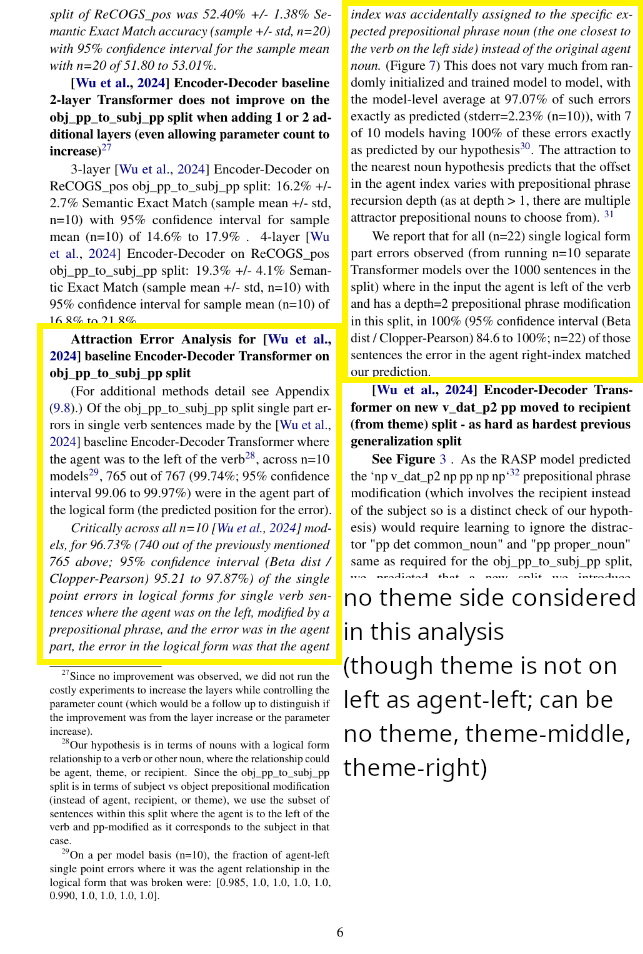


This notebook is only used for the Wu et al baseline Attraction Error analysis results in the paper (see yellow box above) and only agent-left, all theme positions results are reported. Note that the "np v_dat_p2 np pp np np" / new v_dat_p2 moved to recipient from theme split is NOT from this notebook (uses examples generated from augmented training examples, not gen obj-pp-to-subj-pp split used here), see notebook links in paper for that analysis, the v_dat_p2 recipient pp modified analysis of Wu et al baseline IS UNRELATED TO THIS NOTEBOOK.

(End clarifying notes on setup cell added after analysis was completed and written up.)

### Analysis Setup continued

In [ ]:
# log the Lark version in case there is a regression later or incompatibility
import lark
lark.__version__

'1.2.2'

In [ ]:
from collections import defaultdict
import numpy as np

In [ ]:
def is_relation_or_nmod(lf_part):
  return "recipient" in lf_part or "theme" in lf_part or "agent" in lf_part or "nmod" in lf_part

def get_right_idx_from_relation_or_nmod_str(relation_or_nmod_str):
  # redundant safety check just in case
  if not is_relation_or_nmod(relation_or_nmod_str):
    return None
  if "," in relation_or_nmod_str and ")" in relation_or_nmod_str:
    idx_str = relation_or_nmod_str.split(',')[-1].split(')')[0].strip()
    if len(idx_str) == 0:
      print(f"relation_or_nmod_str: '{relation_or_nmod_str}' could not be parsed")
      return None
    return f"{int(idx_str)}"
  else:
    return None

In [ ]:
agent_left_of_verb_errors_total = 0
total_error_count = 0
for data in data_per_seed:
  for wu_et_al_2023_baseline_error_example in data:
    actual = wu_et_al_2023_baseline_error_example["actual"]
    expected = wu_et_al_2023_baseline_error_example["expected"]
    input_text = wu_et_al_2023_baseline_error_example["input"]
    tree = parser.parse(input_text.replace(" .", "").lower().strip())
    agent_side = get_agent_side(tree)
    total_error_count += 1
    if agent_side == "left":
      agent_left_of_verb_errors_total += 1


In [ ]:
total_error_count

8077

In [ ]:
agent_left_of_verb_errors_total

4907

We are going to look at the subset of these errors which are simpler to analyze, single point errors in non-complement phrase, single verb sentences.

In [ ]:
def analyze_cogs_lf_errors_dataframe(data):
  error_counts_map = defaultdict(int)
  error_counts_single_in_sentence_map = defaultdict(int)
  agent_mismatch_matches_nmod_instead_map = defaultdict(int)
  agent_mismatch_matches_nmod_instead_single_in_sentence_map = defaultdict(int)
  example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution = []
  example_agent_left_theme_right_single_point_mismatch_nmod_substitution = []
  example_agent_left_single_point_mismatch_not_nmod_substitution = []
  example_agent_left_single_point_mismatch_nmod_substitution = []
  for didx in range(len(data)):
    datum = data[didx]
    actual = datum["actual"]
    expected = datum["expected"]
    input_text = datum["input"]
    # skip CP examples for this first analysis (this parsing would not work when it is nested complement phrases)
    if "that" in input_text:
      error_counts_map["cp_skip"] += 1
      error_counts_single_in_sentence_map["cp_skip"] += 1
      continue
    actual_splits = actual.replace(" AND ", " ; ").split(";")
    actual_splits = [item.strip() for item in actual_splits]
    expected_splits = expected.replace(" AND ", " ; ").split(";")
    expected_splits = [item.strip() for item in expected_splits]
    tree = parser.parse(input_text.replace(" .", "").lower().strip())
    #verbs = get_verbs(tree)
    # for enforcing during the check of our hypothesis
    # a stricter expectation that the closest prepositional noun to the left of the verb is the misassigned agent (not just any prepositional noun)
    verbs, pps_before_counts, last_noun_before_first_verb_index = get_verbs_with_pps_before_and_last_noun_before_first_verb_index(tree)
    # uncomment below to include v_inf 2 verb case
    if len(verbs) > 1: #and not (len(verbs) == 2 and verbs[0] == "v_inf_taking" and verbs[1] == "v_inf"):
      # let's skip almost all multi-verb cases for the moment in this analysis
      error_counts_map["more_than_one_verb_not_v_inf_skip"] += 1
      error_counts_single_in_sentence_map["more_than_one_verb_not_v_inf_skip"] += 1
      continue
    agent_side = get_agent_side(tree)
    theme_side = get_theme_side(tree)
    if len(actual_splits) != len(expected_splits):
      # excluded from this analysis which focuses on single point errors to start where nothing is entirely omitted
      # this is a different number of parts in the logical form (relationships, entities), not a difference in string length
      error_counts_map[f"diff_length_skip,agent={agent_side},theme={theme_side}"] += 1
      error_counts_single_in_sentence_map[f"diff_length_skip,agent={agent_side},theme={theme_side}"] += 1
      continue
    part_missed = None
    multiple_parts_missed = False
    agent_mismatch_matches_nmod_instead = False
    agent_mismatch_is_expected_for_pp_depth = False
    expected_nmod_right_idxs = set()
    # we are only using this to check whether a noun is in the right-idx of a preposition
    for idx in range(len(expected_splits)):
      expected_part = expected_splits[idx].strip()
      part_type = expected_part.split("(")[0].strip()
      if part_type == "nmod . on" or part_type == "nmod . beside" or part_type == "nmod . in":
        right_idx = get_right_idx_from_relation_or_nmod_str(expected_part)
        if right_idx != None:
          expected_nmod_right_idxs.add(right_idx)
    # note we already excluded examples with a different number of parts in the logical forms
    # it is ok to sort and compare because we are ONLY GOING TO ANALYZE THE SINGLE PART ERROR CASE (not e.g. swapped agent and theme right indices here)
    expected_splits.sort()
    actual_splits.sort()
    for idx in range(len(expected_splits)):
      if len(actual_splits) <= idx:
        actual_part = None
      else:
        actual_part = actual_splits[idx].strip()
      expected_part = expected_splits[idx].strip()
      if actual_part != expected_part:
        print(f"mismatched part: {expected_part} (expected) != {actual_part} (actual)")
        if part_missed != None:
          multiple_parts_missed = True
        part_missed = expected_part.strip().split(" ")[0]
        actual_part_type = actual_part.strip().split(" ")[0]
        error_key = f"agent={agent_side},theme={theme_side},part={part_missed}"
        if part_missed != "theme" and part_missed != "agent" and part_missed != "recipient":
          part_missed = "other"
        elif part_missed != None and part_missed == "agent" and actual_part != None and actual_part_type == "agent" and is_relation_or_nmod(actual_part) and get_right_idx_from_relation_or_nmod_str(actual_part) in expected_nmod_right_idxs:
          # note actual part type will always be agent in this data for part_missed == "agent", but to be clear
          agent_mismatch_matches_nmod_instead = True # but we only count it if it is mismatched and the expected nmod depth for our hypothesis to be strict
          actual_agent_idx = int(get_right_idx_from_relation_or_nmod_str(actual_part))
          if last_noun_before_first_verb_index == actual_agent_idx:
            agent_mismatch_is_expected_for_pp_depth = True
            agent_mismatch_matches_nmod_instead_map[error_key] += 1
        error_counts_map[error_key] += 1
    if multiple_parts_missed:
      error_counts_single_in_sentence_map[f"multiple,agent={agent_side},theme={theme_side}"] += 1
    elif part_missed != None:
      error_key = f"agent={agent_side},theme={theme_side},part={part_missed}"
      error_counts_single_in_sentence_map[error_key] += 1
      if agent_mismatch_matches_nmod_instead and agent_mismatch_is_expected_for_pp_depth:
        agent_mismatch_matches_nmod_instead_single_in_sentence_map[error_key] += 1
        print(f"example agent error substitute nmod instead - input: {input_text}, actual: {actual}, expected: {expected}")
        if agent_side=="left" and part_missed=="agent":
          example_agent_left_single_point_mismatch_nmod_substitution.append(f"input: {input_text}\nactual:  {actual}\nexpected: {expected}\n")
          if theme_side == "right":
            example_agent_left_theme_right_single_point_mismatch_nmod_substitution.append(f"input: {input_text}\nactual:  {actual}\nexpected: {expected}\n")
      else:
        if agent_side=="left" and part_missed=="agent":
          example_agent_left_single_point_mismatch_not_nmod_substitution.append(f"input: {input_text}\nactual:  {actual}\nexpected: {expected}\n")
          if theme_side == "right":
            example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution.append(f"input: {input_text}\nactual:  {actual}\nexpected: {expected}\n")
  print(error_counts_single_in_sentence_map)
  return error_counts_map, error_counts_single_in_sentence_map, agent_mismatch_matches_nmod_instead_single_in_sentence_map, example_agent_left_theme_right_single_point_mismatch_nmod_substitution, example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution, example_agent_left_single_point_mismatch_nmod_substitution, example_agent_left_single_point_mismatch_not_nmod_substitution

In [ ]:
def analyze_error_counts_single_in_sentence_map(error_counts_single_in_sentence_map):
  all_agent_left_keys = [k for k in error_counts_single_in_sentence_map.keys() if k[:10] == "agent=left"]
  expected_agent_left_keys = [k for k in error_counts_single_in_sentence_map.keys() if k[:10] == "agent=left" and k[-10:]=="part=agent"]
  agent_left_has_error_in_agent_count = np.array([error_counts_single_in_sentence_map[key] for key in expected_agent_left_keys]).sum()
  all_agent_left_keys_count = np.array([error_counts_single_in_sentence_map[key] for key in all_agent_left_keys]).sum()
  fraction_in_expected_part = agent_left_has_error_in_agent_count/all_agent_left_keys_count
  return fraction_in_expected_part, agent_left_has_error_in_agent_count, all_agent_left_keys_count

def analyze_agent_mismatch_matches_nmod_instead_single_in_sentence_map(agent_mismatch_matches_nmod_instead_single_in_sentence_map):
  all_agent_left_keys_nmod_single_sentence_errors = [k for k in agent_mismatch_matches_nmod_instead_single_in_sentence_map.keys() if k[:10] == "agent=left"]
  all_agent_left_agent_mismatch_matches_nmod_instead_count = np.array([agent_mismatch_matches_nmod_instead_single_in_sentence_map[k] for k in all_agent_left_keys_nmod_single_sentence_errors]).sum()
  all_agent_left_keys = [k for k in error_counts_single_in_sentence_map.keys() if k[:10] == "agent=left"]
  expected_agent_left_keys = [k for k in error_counts_single_in_sentence_map.keys() if k[:10] == "agent=left" and k[-10:]=="part=agent"]
  all_agent_left_keys_count = np.array([error_counts_single_in_sentence_map[key] for key in all_agent_left_keys]).sum()
  agent_left_expected_categories_count = np.array([error_counts_single_in_sentence_map[key] for key in expected_agent_left_keys]).sum()
  fraction_agent_errors_where_it_was_agent_nmod_substitution = all_agent_left_agent_mismatch_matches_nmod_instead_count/agent_left_expected_categories_count
  fraction_agent_errors_where_it_was_agent_nmod_substitution_theme_right = agent_mismatch_matches_nmod_instead_single_in_sentence_map['agent=left,theme=right,part=agent']/error_counts_single_in_sentence_map['agent=left,theme=right,part=agent']
  count_errors_where_it_was_agent_nmod_substitution_theme_right = agent_mismatch_matches_nmod_instead_single_in_sentence_map['agent=left,theme=right,part=agent']
  count_errors_where_it_was_agent_error_theme_right = error_counts_single_in_sentence_map['agent=left,theme=right,part=agent']
  return fraction_agent_errors_where_it_was_agent_nmod_substitution, fraction_agent_errors_where_it_was_agent_nmod_substitution_theme_right, count_errors_where_it_was_agent_nmod_substitution_theme_right, count_errors_where_it_was_agent_error_theme_right

In [ ]:
fraction_in_expected_part_list = list()
fraction_agent_errors_where_it_was_nmod_substitution_list = list()
fraction_agent_errors_where_it_was_nmod_substitution_theme_right_list = list()
total_agent_left_single_point_error_count = 0
total_agent_left_single_point_error_in_agent_count = 0
total_single_point_agent_errors_theme_right_count = 0
total_single_point_agent_errors_theme_right_count_where_substitution_by_nmod = 0
total_cp_skip_count = 0
total_more_than_one_verb_not_v_inf_skip_count = 0
total_diff_length_skip_count = 0
example_agent_left_theme_right_single_point_mismatch_nmod_substitution_all = []
example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution_all = []
example_agent_left_single_point_mismatch_nmod_substitution_all = []
example_agent_left_single_point_mismatch_not_nmod_substitution_all = []
for data in data_per_seed:
  error_counts_map, error_counts_single_in_sentence_map, agent_mismatch_matches_nmod_instead_single_in_sentence_map, example_agent_left_theme_right_single_point_mismatch_nmod_substitution, example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution, example_agent_left_single_point_mismatch_nmod_substitution, example_agent_left_single_point_mismatch_not_nmod_substitution = analyze_cogs_lf_errors_dataframe(data)
  total_cp_skip_count += error_counts_single_in_sentence_map["cp_skip"]
  total_more_than_one_verb_not_v_inf_skip_count += error_counts_single_in_sentence_map["more_than_one_verb_not_v_inf_skip"]
  total_diff_length_skip_count += error_counts_single_in_sentence_map["diff_length_skip"]
  example_agent_left_theme_right_single_point_mismatch_nmod_substitution_all = example_agent_left_theme_right_single_point_mismatch_nmod_substitution_all + example_agent_left_theme_right_single_point_mismatch_nmod_substitution
  example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution_all = example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution_all + example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution
  example_agent_left_single_point_mismatch_nmod_substitution_all = example_agent_left_single_point_mismatch_nmod_substitution_all + example_agent_left_single_point_mismatch_nmod_substitution
  example_agent_left_single_point_mismatch_not_nmod_substitution_all = example_agent_left_single_point_mismatch_not_nmod_substitution_all + example_agent_left_single_point_mismatch_not_nmod_substitution
  fraction_in_expected_part, agent_left_has_error_in_agent_count, all_agent_left_keys_count = analyze_error_counts_single_in_sentence_map(error_counts_single_in_sentence_map)
  total_agent_left_single_point_error_count += all_agent_left_keys_count
  total_agent_left_single_point_error_in_agent_count += agent_left_has_error_in_agent_count
  fraction_in_expected_part_list.append(fraction_in_expected_part)
  fraction_agent_errors_where_it_was_nmod_substitution, fraction_agent_errors_where_it_was_nmod_substitution_theme_right, count_errors_where_it_was_agent_nmod_substitution_theme_right, count_errors_where_it_was_agent_error_theme_right = analyze_agent_mismatch_matches_nmod_instead_single_in_sentence_map(agent_mismatch_matches_nmod_instead_single_in_sentence_map)
  total_single_point_agent_errors_theme_right_count += count_errors_where_it_was_agent_error_theme_right
  total_single_point_agent_errors_theme_right_count_where_substitution_by_nmod += count_errors_where_it_was_agent_nmod_substitution_theme_right
  fraction_agent_errors_where_it_was_nmod_substitution_list.append(fraction_agent_errors_where_it_was_nmod_substitution)
  fraction_agent_errors_where_it_was_nmod_substitution_theme_right_list.append(fraction_agent_errors_where_it_was_nmod_substitution_theme_right)

Streaming output truncated to the last 5000 lines.
mismatched part: agent ( 5 , 1 ) (expected) != agent ( 5 , 7 ) (actual)
mismatched part: theme ( 5 , 7 ) (expected) != theme ( 5 , 1 ) (actual)
mismatched part: agent ( 5 , 1 ) (expected) != agent ( 5 , 6 ) (actual)
mismatched part: theme ( 5 , 6 ) (expected) != theme ( 5 , 1 ) (actual)
mismatched part: recipient ( 6 , 1 ) (expected) != recipient ( 6 , 8 ) (actual)
mismatched part: theme ( 6 , 8 ) (expected) != theme ( 6 , 1 ) (actual)
mismatched part: recipient ( 6 , 1 ) (expected) != recipient ( 6 , 8 ) (actual)
mismatched part: theme ( 6 , 8 ) (expected) != theme ( 6 , 1 ) (actual)
mismatched part: recipient ( 6 , 1 ) (expected) != recipient ( 6 , 8 ) (actual)
mismatched part: theme ( 6 , 8 ) (expected) != theme ( 6 , 1 ) (actual)
mismatched part: agent ( 5 , 1 ) (expected) != agent ( 5 , 7 ) (actual)
mismatched part: theme ( 5 , 7 ) (expected) != theme ( 5 , 1 ) (actual)
mismatched part: agent ( 5 , 1 ) (expected) != eat ( 5 ) (act

In [ ]:
def get_clopper_pearson_confidence_interval(n, k):
  alpha = 0.05
  from scipy.stats import beta
  # Reference: https://en.wikipedia.org/w/index.php?title=Binomial_proportion_confidence_interval&oldid=1252517214#Clopper%E2%80%93Pearson_interval
  # Wikipedia's underlying reference for the beta distribution form https://arxiv.org/abs/1303.1288 equation 4 is also useful,
  cp_confidence_interval = beta.ppf([alpha/2.0, 1-alpha/2.0], [k, k+1],[n-k + 1, n-k])
  # Below https://arxiv.org/abs/1303.1288 eqn 4 they discuss the n == k and k == 0 cases,
  # which justify the following assignments below and the use of alpha/2.0 (two-tailed test adjustment) above even when we find that k==n or k==0.
  # they give a closed form for these special cases but one can check it is what beta.ppf (which covers all cases) will return there as well.
  if n == k:
    cp_confidence_interval[1] = 1.0
  if k == 0:
    cp_confidence_interval[0] = 0.0
  return cp_confidence_interval

## Results for single-point logical form errors when the agent-is-left-of-the-verb, single verb (v_inf excl, can be incl) no complement phrases (n=767 out of 8077 total errors; 9.5% of raw errors, 15.6% of 4907 agent-is-left-of-the-verb errors; restricted to simplify analysis)

Note that our hypothesis does make similar predictions for theme left of verb in this obj_pp_to_subj_pp split (identical analysis with agent in place of theme), but we start just analyzing the agent errors as they are more common.

agent left of verb sentences (regardless whether single verb or not)

In [ ]:
agent_left_of_verb_errors_total

4907

single point errors in agent left of verb, single verb sentences:

In [ ]:
total_agent_left_single_point_error_count

767

In [ ]:
total_agent_left_single_point_error_in_agent_count

765

In [ ]:
total_agent_left_single_point_error_count / agent_left_of_verb_errors_total

0.15630731607907072

### Summary numbers

In [ ]:
ci = get_clopper_pearson_confidence_interval(total_agent_left_single_point_error_count, total_agent_left_single_point_error_in_agent_count)
print(f"Across all n={len(fraction_in_expected_part_list)} Wu et al 2023 models, " +
 f"{total_agent_left_single_point_error_in_agent_count} out of {total_agent_left_single_point_error_count} " +
 f"({(total_agent_left_single_point_error_in_agent_count/total_agent_left_single_point_error_count)*100:0.2f}%; 95% confidence interval {ci[0]*100:0.2f} to {ci[1]*100:0.2f}%) " +
 f"single point errors in logical forms when the agent was on the left were in the agent part")

Across all n=10 Wu et al 2023 models, 765 out of 767 (99.74%; 95% confidence interval 99.06 to 99.97%) single point errors in logical forms when the agent was on the left were in the agent part


In [ ]:
print(f"On a per model basis, the fraction of agent-left single point errors where the agent was broken were {fraction_in_expected_part_list}\nAverage: {np.array(fraction_in_expected_part_list).mean()}")

On a per model basis, the fraction of agent-left single point errors where the agent was broken were [0.9850746268656716, 1.0, 1.0, 1.0, 1.0, 0.9896907216494846, 1.0, 1.0, 1.0, 1.0]
Average: 0.9974765348515156


In [ ]:
ci = get_clopper_pearson_confidence_interval(len(example_agent_left_single_point_mismatch_nmod_substitution_all) + len(example_agent_left_single_point_mismatch_not_nmod_substitution_all), len(example_agent_left_single_point_mismatch_nmod_substitution_all))

print(f"Across all n={len(fraction_in_expected_part_list)} Wu et al 2023 models, " +
 f"{len(example_agent_left_single_point_mismatch_nmod_substitution_all)} out of {len(example_agent_left_single_point_mismatch_nmod_substitution_all) + len(example_agent_left_single_point_mismatch_not_nmod_substitution_all)} " +
  f"({len(example_agent_left_single_point_mismatch_nmod_substitution_all)/(len(example_agent_left_single_point_mismatch_nmod_substitution_all) + len(example_agent_left_single_point_mismatch_not_nmod_substitution_all))*100:0.2f}%; 95% confidence interval {ci[0]*100:0.2f} to {ci[1]*100:0.2f}%) " +
  "of all single point errors in logical forms where the agent was on the left, modified by a prepositional phrase, and the error was in the agent part\nthe error was as predicted by our hypothesis (agent idx is mistakenly set to the prepositional noun index)\n\n" +
  "(see further down in notebook for a printout of all such examples for verifying manually if desired)"
 )

Across all n=10 Wu et al 2023 models, 740 out of 765 (96.73%; 95% confidence interval 95.21 to 97.87%) of all single point errors in logical forms where the agent was on the left, modified by a prepositional phrase, and the error was in the agent part
the error was as predicted by our hypothesis (agent idx is mistakenly set to the prepositional noun index)

(see further down in notebook for a printout of all such examples for verifying manually if desired)


On a per model basis, the fraction of these agent-left single point errors where the agent was broken that are broken in the predicted way (substitute the prepositional phrase index), averages at 97% (notably, one outlier had only 76% meeting the prediction):

In [ ]:
import math
d = np.array(fraction_agent_errors_where_it_was_nmod_substitution_list)
print(f"Wu et al 2023 baseline Encoder-Decoder Transformer model\n" +
      f"average % of all agent-left sentences with single point error with agent modified by prepositional phrase\n" +
      f"where agent idx in LF is substituted by prepositional noun idx (as predicted): {d.mean()*100:0.2f}%, stderr={d.std()/math.sqrt(len(d))*100:0.2f}% (n={len(d)})\n\nfraction as expected for each training+evaluation run (separate model): {fraction_agent_errors_where_it_was_nmod_substitution_list}")

Wu et al 2023 baseline Encoder-Decoder Transformer model
average % of all agent-left sentences with single point error with agent modified by prepositional phrase
where agent idx in LF is substituted by prepositional noun idx (as predicted): 97.07%, stderr=2.23% (n=10)

fraction as expected for each training+evaluation run (separate model): [0.9696969696969697, 0.7613636363636364, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9761904761904762, 1.0]


Though that already looks like almost all of the single point errors in the logical form when the agent is on the left and modified by prepositional phrase match our prediction,

we can begin the deeper analysis with the simple subject-verb-object case where it is agent-verb-theme, where we also see very high agreement with our prediction (almost 97.10%), but the numbers are fewer so we can actually confirm every single example by eye if we want to:

In [ ]:
ci = get_clopper_pearson_confidence_interval(total_single_point_agent_errors_theme_right_count, total_single_point_agent_errors_theme_right_count_where_substitution_by_nmod)

print(f"{total_single_point_agent_errors_theme_right_count_where_substitution_by_nmod} out of {total_single_point_agent_errors_theme_right_count} single point errors " +
 f"({total_single_point_agent_errors_theme_right_count_where_substitution_by_nmod/total_single_point_agent_errors_theme_right_count*100:0.2f}%; 95% confidence interval {ci[0]*100:0.2f} to {ci[1]*100:0.2f}%) " +
 f"(combining all counts across n=10 models)\nwith nmod agent on left and theme on right are the predicted substitution of agent idx by the prepositional noun idx\n\n(see further down in notebook for a printout of all such examples ofr verifying manually if desired)")

234 out of 241 single point errors (97.10%; 95% confidence interval 94.11 to 98.82%) (combining all counts across n=10 models)
with nmod agent on left and theme on right are the predicted substitution of agent idx by the prepositional noun idx

(see further down in notebook for a printout of all such examples ofr verifying manually if desired)


If we look at the fraction by each separately trained-from-scratch Wu et al 2023 Encoder-Decoder Transformer, we see our hypothesis predicted the error successfully for all the agent-left , theme-right errors for 8 out of 10 Transformers, and for 2 out of 10 it predicted the vast majority, and on average we predict 97.9% (average across models):

In [ ]:
import math
d = np.array(fraction_agent_errors_where_it_was_nmod_substitution_theme_right_list)
print(f"Wu et al 2023 baseline Encoder-Decoder Transformer model\n" +
      f"average % of agent-verb-theme sentence single point LF errors with agent modified by prepositional phrase\n" +
      f"where agent idx in LF is substituted by prepositional noun idx: {d.mean()*100:0.2f}%, stderr={d.std()/math.sqrt(len(d))*100:0.2f}% (mean +/- std, n={len(d)})\n\n fraction as predicted for each training+evaluation run (separate models): {fraction_agent_errors_where_it_was_nmod_substitution_theme_right_list}")

Wu et al 2023 baseline Encoder-Decoder Transformer model
average % of agent-verb-theme sentence single point LF errors with agent modified by prepositional phrase
where agent idx in LF is substituted by prepositional noun idx: 97.85%, stderr=1.63% (mean +/- std, n=10)

 fraction as predicted for each training+evaluation run (separate models): [0.9565217391304348, 0.8285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Here are the actual sentences with actual and predicted logical forms:

### Example sentences for simple non-dative agent-left, theme-right single point mismatches (smaller set for verifying all by hand if desired)

Note sentences occur more than once and can occur in both "As predicted" and "Not as predicted" conditions because this is the combined output from n=10 separate Transformers with different behavior. Each sentence does not appear 10 times because we only consider logical form output with single point errors and also if they get it correct it would not be included in the analysis.

This is an analysis of the errors Wu et al 2023's baseline Encoder-Decoder Transformer makes on the obj_pp_to_subj_pp split from https://github.com/frankaging/ReCOGS/blob/1b6eca8ff4dca5fd2fb284a7d470998af5083beb/recogs_positional_index/gen.tsv (public data; was held out for evaluations of our RASP model , this analysis of the Wu et al baseline errors on it only done after the RASP evaluation on that split was completed).

#### Wu et al 2023 baseline model error AS predicted (234 out of 241; 97.1%)

In [ ]:
len(example_agent_left_theme_right_single_point_mismatch_nmod_substitution_all)

234

In [ ]:
for example in example_agent_left_theme_right_single_point_mismatch_nmod_substitution_all:
  print(example)

input: A girl on the stool on the table drew a frog .
actual:   girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: The professor beside a table appreciated the key in a room .
actual:   * professor ( 1 ) ; table ( 4 ) ; * key ( 7 ) ; room ( 10 ) ; nmod . beside ( 1 , 4 ) AND appreciate ( 5 ) AND agent ( 5 , 4 ) AND theme ( 5 , 7 ) AND nmod . in ( 7 , 10 )
expected: * professor ( 1 ) ; table ( 4 ) ; * key ( 7 ) ; room ( 10 ) ; nmod . beside ( 1 , 4 ) AND appreciate ( 5 ) AND agent ( 5 , 1 ) AND theme ( 5 , 7 ) AND nmod . in ( 7 , 10 )

input: A scientist on the desk admired the cake beside the chair .
actual:   scientist ( 1 ) ; * desk ( 4 ) ; * cake ( 7 ) ; * chair ( 10 ) ; nmod . on ( 1 , 4 ) AND admire (

#### Wu et al 2023 baseline model error NOT AS predicted (7 out of 241; 2.9%)

In [ ]:
len(example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution_all)

7

In [ ]:
for example in example_agent_left_theme_right_single_point_mismatch_not_nmod_substitution_all:
  print(example)

input: The mouse in the crate liked a professor on the road .
actual:   * mouse ( 1 ) ; * crate ( 4 ) ; professor ( 7 ) ; * road ( 10 ) ; nmod . in ( 1 , 4 ) AND like ( 5 ) AND agent ( 5 , 7 ) AND theme ( 5 , 7 ) AND nmod . on ( 7 , 10 )
expected: * mouse ( 1 ) ; * crate ( 4 ) ; professor ( 7 ) ; * road ( 10 ) ; nmod . in ( 1 , 4 ) AND like ( 5 ) AND agent ( 5 , 1 ) AND theme ( 5 , 7 ) AND nmod . on ( 7 , 10 )

input: A boy in the trailer poked the girl beside a table .
actual:   boy ( 1 ) ; * trailer ( 4 ) ; * girl ( 7 ) ; table ( 10 ) ; nmod . in ( 1 , 4 ) AND poke ( 5 ) AND agent ( 5 , 7 ) AND theme ( 5 , 7 ) AND nmod . beside ( 7 , 10 )
expected: boy ( 1 ) ; * trailer ( 4 ) ; * girl ( 7 ) ; table ( 10 ) ; nmod . in ( 1 , 4 ) AND poke ( 5 ) AND agent ( 5 , 1 ) AND theme ( 5 , 7 ) AND nmod . beside ( 7 , 10 )

input: A student in a pot liked the girl on a chair .
actual:   student ( 1 ) ; pot ( 4 ) ; * girl ( 7 ) ; chair ( 10 ) ; nmod . in ( 1 , 4 ) AND like ( 5 ) AND agent ( 5 , 7 )

### Example sentences for agent-left, single point mismatches (theme anywhere; this covers all such errors where we have a prediction)

Note sentences occur more than once and can occur in both "As predicted" and "Not as predicted" conditions because this is the combined output from n=10 separate Transformers with different behavior. Each sentence does not appear 10 times because we only consider logical form output with single point errors and also if they get it correct it would not be included in the analysis.

#### Wu et al 2023 baseline model error AS predicted (740 out of 765; 96.7%)

We assert here that the input sentence had the agent left of the verb modified by a prepositional noun phrase and that the baseline model made a single part error in the Logical Form, and that the error was that the agent of the verb was replaced with the closest prepositional noun to the left of the verb.

(Note the same sentences can appear multiple times (up to 10 times) because we combined the errors from 10 different runs)

In [ ]:
len(example_agent_left_single_point_mismatch_nmod_substitution_all)

740

In [ ]:
for example in example_agent_left_single_point_mismatch_nmod_substitution_all:
  print(example)

input: A girl on the stool on the table drew a frog .
actual:   girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: A girl in the house slept .
actual:   girl ( 1 ) ; * house ( 4 ) ; nmod . in ( 1 , 4 ) AND sleep ( 5 ) AND agent ( 5 , 4 )
expected: girl ( 1 ) ; * house ( 4 ) ; nmod . in ( 1 , 4 ) AND sleep ( 5 ) AND agent ( 5 , 1 )

input: The professor beside a table appreciated the key in a room .
actual:   * professor ( 1 ) ; table ( 4 ) ; * key ( 7 ) ; room ( 10 ) ; nmod . beside ( 1 , 4 ) AND appreciate ( 5 ) AND agent ( 5 , 4 ) AND theme ( 5 , 7 ) AND nmod . in ( 7 , 10 )
expected: * professor ( 1 ) ; table ( 4 ) ; * key ( 7 ) ; room ( 10 ) ; nmod . beside ( 1 , 4 ) AND appreciate ( 5 ) AND agent ( 5 

#### Wu et al 2023 baseline model error NOT AS predicted (25 out of 765; 3.3%)

In [ ]:
len(example_agent_left_single_point_mismatch_not_nmod_substitution_all)

25

In [ ]:
for example in example_agent_left_single_point_mismatch_not_nmod_substitution_all:
  print(example)

input: A girl in a envelope sold Liam the cake beside the computer .
actual:   girl ( 1 ) ; envelope ( 4 ) ; Liam ( 6 ) ; * cake ( 8 ) ; * computer ( 11 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 6 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 ) AND nmod . beside ( 8 , 11 )
expected: girl ( 1 ) ; envelope ( 4 ) ; Liam ( 6 ) ; * cake ( 8 ) ; * computer ( 11 ) ; nmod . in ( 1 , 4 ) AND sell ( 5 ) AND agent ( 5 , 1 ) AND recipient ( 5 , 6 ) AND theme ( 5 , 8 ) AND nmod . beside ( 8 , 11 )

input: The mouse in the crate liked a professor on the road .
actual:   * mouse ( 1 ) ; * crate ( 4 ) ; professor ( 7 ) ; * road ( 10 ) ; nmod . in ( 1 , 4 ) AND like ( 5 ) AND agent ( 5 , 7 ) AND theme ( 5 , 7 ) AND nmod . on ( 7 , 10 )
expected: * mouse ( 1 ) ; * crate ( 4 ) ; professor ( 7 ) ; * road ( 10 ) ; nmod . in ( 1 , 4 ) AND like ( 5 ) AND agent ( 5 , 1 ) AND theme ( 5 , 7 ) AND nmod . on ( 7 , 10 )

input: A donkey in the room sold Ella a donut .
actual:   donkey ( 1 ) ; * room ( 4

Note that about half of the errors not matching our predicted form for the obj_pp_to_subj_pp split are the Wu et al 2023 baseline Transformer adding "AND" onto the end (this does not lessen our prediction, this is a separate error mechanism and is relatively rare).

In the few other cases, a different noun is substituted.

## Testing the prediction that for pp depth 1 vs depth 2 the Wu et al 2023 baseline Transformer misassigned agent index changes predictably (for agent left of verb, should the closest pp noun on left to the verb) (obsolete, combined into above)

(in this simple grammar either `+3*(pp depth)` or `3*(pp depth)-1` if the last noun is a proper noun; nouns modified by preposition cannot be proper nouns in this grammar, but the point is that we predict it is the closest noun on the left, however these offsets are useful)

(note can be 3*(pp depth) - 1 if the trailing noun phrase in the prepositional phrase chain is a proper noun; note that proper nouns cannot be modified by prepositional phrases so only the rightmost one can; `Noah beside Liam` is not allowed in this grammar but `a boy beside Liam` is)

Testing predictions by RASP model of specific logical form errors by Wu et al 2023 baseline Encoder-Decoder Transformer - confirm pp depth 1 vs 2 changes agent misattribution to the closest pp noun as predicted (e.g. if agent 1, from 1 to 4  for depth 1, but 1 to 7 for depth 2).

It the examples I listed above it is already clearly the case that as we would expect for the mechanism of verb relationship matching being a flat fixed pattern match as we do in the RASP model, we see

e.g. for pp depth 1, as expected the mistake is to put agent index 4 instead of 1 (1 + 3*1 == 4) (no proper noun in last preposition so add 3, for "pp det common_noun", if had been proper noun would be "pp proper_noun", +2 instead):
```
input: The baby beside a valve painted the cake .
actual:   * baby ( 1 ) ; valve ( 4 ) ; * cake ( 7 ) ; nmod . beside ( 1 , 4 ) AND paint ( 5 ) AND agent ( 5 , 4 ) AND theme ( 5 , 7 )
expected: * baby ( 1 ) ; valve ( 4 ) ; * cake ( 7 ) ; nmod . beside ( 1 , 4 ) AND paint ( 5 ) AND agent ( 5 , 1 ) AND theme ( 5 , 7 )
```

whereas e.g. for pp depth 2 on the agent left of the verb, as expected the mistake is to put agent index 7 instead of 1 (the pp noun closest to the verb steals it, not the other pp noun at index 4):

```
input: A girl on the stool on the table drew a frog .
actual:   girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )
```

but I had not yet measured/tested that aspect in the summary metrics of the first analysis to confirm it is generally holding.

Since the error formula in the agent-left-of-verb case for this grammar where proper nouns cannot be on the left side of a nmod in this grammar:

(this is what we expect the baseline Wu et al 2023 Transformer to do by mistake)
```
(actual index predicted) = (expected index) + 3 * (num pp before verb) (-1 if last prepositional noun is a proper noun)
```

All examples filtered from above (n=22) for pp depth 2 (single verb, agent on left, from obj-pp-to-subj-pp) were consistent with the hypothesis that it was the nearest noun to the verb that was mistaken for the agent (see below). When pp depth is 2, there are two attractor prepositional phrase nouns that have been added between the agent and the verb, but we predicted the one closer to the verb would take it which is the case in all pp depth 2 sentences with an error in the logical form across n=10 Wu et al baseline Transformer models (see examples below).

```
input: A girl on the stool on the table drew a frog .
actual:   girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: The dog on the platter beside a stage slept .
actual:   * dog ( 1 ) ; * platter ( 4 ) ; stage ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: * dog ( 1 ) ; * platter ( 4 ) ; stage ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: The girl beside the tree in the bookstore slept .
actual:   * girl ( 1 ) ; * tree ( 4 ) ; * bookstore ( 7 ) ; nmod . beside ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: * girl ( 1 ) ; * tree ( 4 ) ; * bookstore ( 7 ) ; nmod . beside ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: The girl in the house beside a cage dusted a ball .
actual:   * girl ( 1 ) ; * house ( 4 ) ; cage ( 7 ) ; ball ( 10 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND dust ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: * girl ( 1 ) ; * house ( 4 ) ; cage ( 7 ) ; ball ( 10 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND dust ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: A creature in a house beside the book slept .
actual:   creature ( 1 ) ; house ( 4 ) ; * book ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: creature ( 1 ) ; house ( 4 ) ; * book ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: The baby on a tray in the house screamed .
actual:   * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 7 )
expected: * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )

input: The dog on the platter beside a stage slept .
actual:   * dog ( 1 ) ; * platter ( 4 ) ; stage ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: * dog ( 1 ) ; * platter ( 4 ) ; stage ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: The girl beside the tree in the bookstore slept .
actual:   * girl ( 1 ) ; * tree ( 4 ) ; * bookstore ( 7 ) ; nmod . beside ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: * girl ( 1 ) ; * tree ( 4 ) ; * bookstore ( 7 ) ; nmod . beside ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: A child in a room on a stage smiled .
actual:   child ( 1 ) ; room ( 4 ) ; stage ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND smile ( 8 ) AND agent ( 8 , 7 )
expected: child ( 1 ) ; room ( 4 ) ; stage ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND smile ( 8 ) AND agent ( 8 , 1 )

input: The baby on a tray in the house screamed .
actual:   * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 7 )
expected: * baby ( 1 ) ; tray ( 4 ) ; * house ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND scream ( 8 ) AND agent ( 8 , 1 )

input: A girl on the stool on the table drew a frog .
actual:   girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: The director on a bed on the machine lended a farmer the sandwich .
actual:   * director ( 1 ) ; bed ( 4 ) ; * machine ( 7 ) ; farmer ( 10 ) ; * sandwich ( 12 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND lend ( 8 ) AND agent ( 8 , 7 ) AND recipient ( 8 , 10 ) AND theme ( 8 , 12 )
expected: * director ( 1 ) ; bed ( 4 ) ; * machine ( 7 ) ; farmer ( 10 ) ; * sandwich ( 12 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND lend ( 8 ) AND agent ( 8 , 1 ) AND recipient ( 8 , 10 ) AND theme ( 8 , 12 )

input: The girl in the house beside a cage dusted a ball .
actual:   * girl ( 1 ) ; * house ( 4 ) ; cage ( 7 ) ; ball ( 10 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND dust ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: * girl ( 1 ) ; * house ( 4 ) ; cage ( 7 ) ; ball ( 10 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND dust ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: The dog in a bakery in the bag sneezed .
actual:   * dog ( 1 ) ; bakery ( 4 ) ; * bag ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sneeze ( 8 ) AND agent ( 8 , 7 )
expected: * dog ( 1 ) ; bakery ( 4 ) ; * bag ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sneeze ( 8 ) AND agent ( 8 , 1 )

input: The girl beside the tree in the bookstore slept .
actual:   * girl ( 1 ) ; * tree ( 4 ) ; * bookstore ( 7 ) ; nmod . beside ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: * girl ( 1 ) ; * tree ( 4 ) ; * bookstore ( 7 ) ; nmod . beside ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: A girl on the stool on the table drew a frog .
actual:   girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * stool ( 4 ) ; * table ( 7 ) ; frog ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND draw ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: The dog on the platter beside a stage slept .
actual:   * dog ( 1 ) ; * platter ( 4 ) ; stage ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: * dog ( 1 ) ; * platter ( 4 ) ; stage ( 7 ) ; nmod . on ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: The director on a bed on the machine lended a farmer the sandwich .
actual:   * director ( 1 ) ; bed ( 4 ) ; * machine ( 7 ) ; farmer ( 10 ) ; * sandwich ( 12 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND lend ( 8 ) AND agent ( 8 , 7 ) AND recipient ( 8 , 10 ) AND theme ( 8 , 12 )
expected: * director ( 1 ) ; bed ( 4 ) ; * machine ( 7 ) ; farmer ( 10 ) ; * sandwich ( 12 ) ; nmod . on ( 1 , 4 ) AND nmod . on ( 4 , 7 ) AND lend ( 8 ) AND agent ( 8 , 1 ) AND recipient ( 8 , 10 ) AND theme ( 8 , 12 )

input: A girl on the corpse in a glass admired a teacher .
actual:   girl ( 1 ) ; * corpse ( 4 ) ; glass ( 7 ) ; teacher ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND admire ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: girl ( 1 ) ; * corpse ( 4 ) ; glass ( 7 ) ; teacher ( 10 ) ; nmod . on ( 1 , 4 ) AND nmod . in ( 4 , 7 ) AND admire ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: The girl in the house beside a cage dusted a ball .
actual:   * girl ( 1 ) ; * house ( 4 ) ; cage ( 7 ) ; ball ( 10 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND dust ( 8 ) AND agent ( 8 , 7 ) AND theme ( 8 , 10 )
expected: * girl ( 1 ) ; * house ( 4 ) ; cage ( 7 ) ; ball ( 10 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND dust ( 8 ) AND agent ( 8 , 1 ) AND theme ( 8 , 10 )

input: A creature in a house beside the book slept .
actual:   creature ( 1 ) ; house ( 4 ) ; * book ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 7 )
expected: creature ( 1 ) ; house ( 4 ) ; * book ( 7 ) ; nmod . in ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND sleep ( 8 ) AND agent ( 8 , 1 )

input: The lion beside a stage beside the bench gave a girl the pillow .
actual:   * lion ( 1 ) ; stage ( 4 ) ; * bench ( 7 ) ; girl ( 10 ) ; * pillow ( 12 ) ; nmod . beside ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND give ( 8 ) AND agent ( 8 , 7 ) AND recipient ( 8 , 10 ) AND theme ( 8 , 12 )
expected: * lion ( 1 ) ; stage ( 4 ) ; * bench ( 7 ) ; girl ( 10 ) ; * pillow ( 12 ) ; nmod . beside ( 1 , 4 ) AND nmod . beside ( 4 , 7 ) AND give ( 8 ) AND agent ( 8 , 1 ) AND recipient ( 8 , 10 ) AND theme ( 8 , 12 )
```

Code to produce pp depth == 2 analysis above available upon request, at the bottom of https://colab.research.google.com/drive/1cmKPu17lp5jvatsLYSTuHu5bHeABgDE8 . Can be checked manually by readers by reviewing errors earlier in this notebook (above are the pp depth == 2 examples filtered from the errors already printed in this notebook). Note the same input sentence can occur more than once as these are combined errors from n=10 independently trained Wu et al baseline Transformer models.